## NBA simulatore

- [x] calendario partite 2021 > NBA21sched  
- [x] PREDITTORE PER TUTTA STAGIONE .. loop , utilizza cfr di PLUS_MINUS_RANK stagione passata per squadra 
- [x] stats medie per squadra > AVG_TEAM_STATS_PRESEASON
- [x] fare lista partite per data 
- [x] provato predittore su partite passate = 68% 
- [x] imparatto a ottimizzare funzione, ma scritta cosi non ha senso . ovvio che massimizzo se le indovino tutte! 
- [ ] nuova funzione !! 
- [ ] provare fantasywidget per singoli giocatori .. fatto sotto, affinare 
- [ ] stato infortuni ? 
- [ ] arricchire criterio .. - giocatori on fire, striscia positiva , salute , +-, , efficienza

- 201220 minimizzare chiamate facendo cella con chiamata che salva su DF e altra cella per lavorare sul DF 
- 201220 aggiunto ODDS ( sistemare data ) 
- 201220 corretto formula guadagno 
- 201220 dubbio. il mio algoritmo non puo vincere contro odds

- https://github.com/swar/nba_api/blob/master/docs/table_of_contents.md
- https://app.slack.com/client/TGCSU1HDW/CGDKENXGS/thread/CGDKENXGS-1607890992.090800



<div class="alert-warning">
        
# CHECK PARTITE DAILY vs PREDIZIONE 
- https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/playergamelog.md    
- https://stackoverflow.com/questions/57763470/pandas-get-second-row-and-put-it-at-the-end-of-first-row-and-automatically-cre    
</div>

### load all data

### predict2 function + test on historical data

In [232]:

def PREDICT2(df,TEAM1,TEAM2):
    A = teams.loc[teams['abbreviation'] == TEAM1]['id'].values[0]
    B = teams.loc[teams['abbreviation'] == TEAM2]['id'].values[0]
    A1 = (df.loc[df['TEAM_ID'] == A]['PLUS_MINUS_RANK'].values[0])
    A2 = (df.loc[df['TEAM_ID'] == A]['TEAM_NAME'].values[0])
    B1 = (df.loc[df['TEAM_ID'] == B]['PLUS_MINUS_RANK'].values[0])
    B2 = (df.loc[df['TEAM_ID'] == B]['TEAM_NAME'].values[0])
    if A1<B1:
        win=TEAM1
    else:
        win=TEAM2
    return(win,min(A1,B1),max(A1,B1))

df1=gameslog[['GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID','TEAM_ABBREVIATION','TEAM_CITY_NAME','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2=df1[['GAME_DATE_EST','GAME_ID','TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2

df3 = pd.DataFrame([y.values.ravel() for x , y in df2.groupby(np.arange(len(df2))//2)])
df3.columns= ['DATEA','GAME_IDA','TEAMA','PTSA','FG_PCTA','FT_PCTA','FG3_PCTA','ASTA','REBA','TOVA','DATEH','GAME_IDH','TEAMH','PTSH','FG_PCTH','FT_PCTH','FG3_PCTH','ASTH','REBH','TOVH']
df3=df3[['DATEA','GAME_IDH','TEAMH','PTSH','TEAMA','PTSA','FG_PCTH','FG_PCTA','FT_PCTH','FT_PCTA','FG3_PCTH','FG3_PCTA','ASTH','ASTA','REBH','REBA','TOVH','TOVA']]
df3['WIN']=''

for i, row in df3.iterrows():
    if (row['PTSH']> row['PTSA']):
        df3.at[i,'WIN'] = row['TEAMH']
    else:
        df3.at[i,'WIN'] = row['TEAMH']

i=0
for index, row in df3.iterrows():
    TEAM1 = row['TEAMH'][:3]
    TEAM2 = row['TEAMA'][:3]
    OUT = PREDICT2(avg_stats,TEAM1,TEAM2)
    df3.at[i, 'PREDICT'] = OUT[0]
    df3.at[i, 'SCORELOSE'] = OUT[1]
    df3.at[i, 'SCOREWIN'] = OUT[2]
    df3.at[i, 'SCORELOSE'] = OUT[1]
    df3.at[i, 'SCOREDELTA'] = OUT[2]-OUT[1]
    df3.at[i, 'SCOREDELTAPERC1'] = ((OUT[2]-OUT[1])/OUT[1])
    df3.at[i, 'SCOREDELTAPERC2'] = '{0:.2f}'.format((OUT[2]-OUT[1])/OUT[1])
    if (row['WIN']== OUT[0]):
        df3.at[i,'PREDICT_CHECK'] = 'GOOD'
    else:
        df3.at[i,'PREDICT_CHECK'] = 'BAD'
    i=i+1
    
df3=df3.sort_values(by='SCOREDELTAPERC1', ascending=False)


z = df3.groupby(['PREDICT_CHECK'])["PREDICT_CHECK"].count().reset_index(name="count")
cBAD = z.iat[0,1]
cGOOD = z.iat[1,1]
PRED_SCORE = cGOOD/(cGOOD+cBAD)
print('cGOOD,cBAD,PRED_SCORE',cGOOD,cBAD,PRED_SCORE)

cGOOD,cBAD,PRED_SCORE 16 6 0.7272727272727273


## Bet win + optimization

In [82]:
PREDIC_SCORE = PRED_SCORE
RSGAMES = 558
HANDICAP=1.5
BET=10

RSGAMESW = (RSGAMES*PREDIC_SCORE)
RSGAMESL=RSGAMES-RSGAMESW
DELTAWL=RSGAMESW-RSGAMESL
MONEYBET= BET*RSGAMES
MONEYWON=int(RSGAMESW*HANDICAP*BET)
DELTA= int(MONEYWON-MONEYBET)

DELTAZ= (((RSGAMES*PREDIC_SCORE))*HANDICAP*BET)-(BET*RSGAMES)
DELTAZ= int((BET*RSGAMES)*((PREDIC_SCORE*HANDICAP)-1))

print("MONEYBET",MONEYBET)
print("MONEYWON",MONEYWON)
print("DELTA",DELTA)
print("DELTA",DELTAZ)


MONEYBET 5580
MONEYWON 6087
DELTA 507
DELTA 507


- POSSO definire una probabilita di vittoria e non puntare sotto una certa % 
- in questo scenario io scommetto sempre e sempre la stessa cifra .. potrei anche variare la scommessa al variare delle possibilita di vittoria 
- handicap variabile , tanto di piu se partita è sbilanciata 
- puntare su partite sbilanciate o partite facili ? cercare partite dove credo di battere l'handicap ? 

In [237]:
from scipy.optimize import minimize

def f(x):
    return -int((x[2]*RSGAMES)*((x[0]*x[1])-1))

x0 = [0.4, 1.0, 2.0]

#real data Ranges 
#x[0] 0..1    
#x[1] 1..3
#x[2] 5..50

cons=( 
        {'type': 'ineq','fun': lambda x: x[0]},
        {'type': 'ineq','fun': lambda x: 1-x[0]},
        {'type': 'ineq','fun': lambda x: x[1]-1},
        {'type': 'ineq','fun': lambda x: 3-x[1]},
        {'type': 'ineq','fun': lambda x: x[2]-5},
        {'type': 'ineq','fun': lambda x: 50-x[2]}
)

res = minimize(f, x0, constraints=cons, method="cobyla")
print(res)

#print (format(-7.39557099e-32, 'f'))

     fun: -55800.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 70
  status: 1
 success: True
       x: array([ 1.,  3., 50.])


<div class="alert-warning">
        
# SCARICA ODDS 
     
</div>

In [398]:
import json
import requests

api_key = '47790af09458f96c2b9a9a5c4a0f7617'

# First get a list of in-season sports
# sports_response = requests.get('https://api.the-odds-api.com/v3/sports', params={'api_key': api_key})
# sports_json = json.loads(sports_response.text)
# if not sports_json['success']:
#     print('There was a problem with the sports request:',sports_json['msg'])
# else:
#     print('Successfully got {} sports'.format(len(sports_json['data'])),'Here\'s the first sport:')
#     print(sports_json['data'][0])

# To get odds for a sepcific sport, use the sport key from the last request
#   or set sport to "upcoming" to see live and upcoming across all sports
sport_key = 'basketball_nba'

odds_response = requests.get('https://api.the-odds-api.com/v3/odds', params={
    'api_key': api_key,
    'sport': sport_key,
    'region': 'eu', # uk | us | eu | au
    'mkt': 'h2h' # h2h | spreads | totals
})

odds_json = json.loads(odds_response.text)

if not odds_json['success']:
    print('There was a problem with the odds request:',odds_json['msg'])
else:
    # odds_json['data'] contains a list of live and 
    #   upcoming events and odds for different bookmakers.
    # Events are ordered by start time (live events are first)
    print('Successfully got {} events'.format(len(odds_json['data'])),'Here\'s the first event:')
    print(odds_json['data'][0])
        
    # Check your usage
    print('Remaining requests', odds_response.headers['x-requests-remaining'])
    print('Used requests', odds_response.headers['x-requests-used'])


Successfully got 10 events Here's the first event:
{'sport_key': 'basketball_nba', 'sport_nice': 'NBA', 'teams': ['Chicago Bulls', 'Washington Wizards'], 'commence_time': 1609287000, 'home_team': 'Washington Wizards', 'sites': [{'site_key': 'unibet', 'site_nice': 'Unibet', 'last_update': 1609262154, 'odds': {'h2h': [3.05, 1.4]}}, {'site_key': 'sport888', 'site_nice': '888sport', 'last_update': 1609262367, 'odds': {'h2h': [3.05, 1.4]}}, {'site_key': 'betclic', 'site_nice': 'Betclic', 'last_update': 1609262340, 'odds': {'h2h': [3.16, 1.44, 15.0]}}, {'site_key': 'betonlineag', 'site_nice': 'BetOnline.ag', 'last_update': 1609262299, 'odds': {'h2h': [3.1, 1.4]}}, {'site_key': 'nordicbet', 'site_nice': 'Nordic Bet', 'last_update': 1609262273, 'odds': {'h2h': [3.0, 1.4]}}, {'site_key': 'betfair', 'site_nice': 'Betfair', 'last_update': 1609262240, 'odds': {'h2h': [3.2, 1.44], 'h2h_lay': [3.25, 1.46]}}, {'site_key': 'marathonbet', 'site_nice': 'Marathon Bet', 'last_update': 1609262360, 'odds': 

In [441]:
dfj = pd.json_normalize(odds_json['data'])
dfj = dfj[['teams', 'commence_time', 'home_team']]
print(dfj.shape[0])

j=0

for index, row in dfj.iterrows():
    dfj.at[j, 'team1'] = odds_json['data'][j]['teams'][0]
    dfj.at[j, 'team2'] = odds_json['data'][j]['teams'][1]
    dfj.at[j, 'site1'] = odds_json['data'][j]['sites'][0]['site_key']
    dfj.at[j, 'site2'] = odds_json['data'][j]['sites'][1]['site_key']
    dfj.at[j, 'site3'] = odds_json['data'][j]['sites'][2]['site_key']
    dfj.at[j, 's1odds1'] = odds_json['data'][j]['sites'][0]['odds']['h2h'][0]
    dfj.at[j, 's2odds1'] = odds_json['data'][j]['sites'][1]['odds']['h2h'][0]
    dfj.at[j, 's3odds1'] = odds_json['data'][j]['sites'][2]['odds']['h2h'][0]
    dfj.at[j, 's1odds2'] = odds_json['data'][j]['sites'][0]['odds']['h2h'][1]
    dfj.at[j, 's2odds2'] = odds_json['data'][j]['sites'][1]['odds']['h2h'][1]
    dfj.at[j, 's3odds2'] = odds_json['data'][j]['sites'][2]['odds']['h2h'][1]
    j=j+1

col = dfj.loc[: , "s1odds1":"s3odds1"]
dfj['MinOdds1'] = col.min(axis=1)
dfj['MaxOdds1'] = col.max(axis=1)
dfj['AvgOdds1'] = col.mean(axis=1)
col = dfj.loc[: , "s1odds2":"s3odds2"]
dfj['MinOdds2'] = col.min(axis=1)
dfj['MaxOdds2'] = col.max(axis=1)
dfj['AvgOdds2'] = col.mean(axis=1)

dfj = dfj[['teams', 'commence_time', 'home_team', 'team1', 'team2','AvgOdds1','AvgOdds2','MinOdds1','MinOdds2', 'MaxOdds1','MaxOdds2']]
dfj.head()

10


(10, 11)

In [449]:

# ADD TEAMS SHORT NAME + HOME/AWAY + KEY 

from nba_api.stats.static import teams
import pandas as pd
teams = pd.DataFrame(teams.get_teams())
teams=teams[['full_name', 'abbreviation']]
teams.head()

teams = teams.rename(columns={'full_name': 'team1','abbreviation': 'team1S'})
odds1 = pd.merge(dfj, teams)
odds1
teams = teams.rename(columns={'team1': 'team2','team1S': 'team2S'})
odds2 = pd.merge(odds1, teams)

i=0
for i, row in odds2.iterrows():
    if row['home_team']==row['team1']:
        tteamh=row['team1S']
        tteama=row['team2S']
    else:
        tteamh=row['team2S']
        tteama=row['team1S']        
    odds2.at[i, 'TEAMH'] = tteamh
    odds2.at[i, 'TEAMA'] = tteama
    odds2.at[i, 'GAMETEAMS'] = tteamh+tteama
    i=i+1

#FIX1

,teams,commence_time,home_team,team1,team2,AvgOdds1,AvgOdds2,MinOdds1,MinOdds2,MaxOdds1,MaxOdds2,team1S,team2S,TEAMH,TEAMA,GAMETEAMS
0,"[Chicago Bulls, Washington Wizards]",1609287000,Washington Wizards,Chicago Bulls,Washington Wizards,3.09,1.41,3.05,1.40,3.16,1.44,CHI,WAS,WAS,CHI,WASCHI
1,"[Boston Celtics, Indiana Pacers]",1609287000,Indiana Pacers,Boston Celtics,Indiana Pacers,1.95,1.93,1.92,1.92,2.02,1.94,BOS,IND,IND,BOS,INDBOS
2,"[Cleveland Cavaliers, New York Knicks]",1609287000,Cleveland Cavaliers,Cleveland Cavaliers,New York Knicks,1.66,2.30,1.64,2.25,1.70,2.35,CLE,NYK,CLE,NYK,CLENYK
3,"[Philadelphia 76ers, Toronto Raptors]",1609287000,Philadelphia 76ers,Philadelphia 76ers,Toronto Raptors,1.86,2.03,1.83,2.02,1.92,2.06,PHI,TOR,PHI,TOR,PHITOR
4,"[Detroit Pistons, Golden State Warriors]",1609287000,Detroit Pistons,Detroit Pistons,Golden State Warriors,2.55,1.56,2.51,1.54,2.60,1.57,DET,GSW,DET,GSW,DETGSW
5,"[Miami Heat, Milwaukee Bucks]",1609288800,Miami Heat,Miami Heat,Milwaukee Bucks,2.83,1.46,2.80,1.45,2.89,1.47,MIA,MIL,MIA,MIL,MIAMIL
6,"[Oklahoma City Thunder, Orlando Magic]",1609290600,Oklahoma City Thunder,Oklahoma City Thunder,Orlando Magic,2.74,1.51,2.70,1.48,2.77,1.54,OKC,ORL,OKC,ORL,OKCORL
7,"[New Orleans Pelicans, Phoenix Suns]",1609297800,Phoenix Suns,New Orleans Pelicans,Phoenix Suns,2.21,1.71,2.20,1.70,2.24,1.73,NOP,PHX,PHX,NOP,PHXNOP
8,"[Los Angeles Clippers, Minnesota Timberwolves]",1609297800,Los Angeles Clippers,Los Angeles Clippers,Minnesota Timberwolves,1.19,5.15,1.18,4.85,1.22,5.60,LAC,MIN,LAC,MIN,LACMIN
9,"[Denver Nuggets, Sacramento Kings]",1609297800,Sacramento Kings,Denver Nuggets,Sacramento Kings,1.75,2.16,1.74,2.15,1.77,2.17,DEN,SAC,SAC,DEN,SACDEN


(10, 13)

<div class="alert-warning">
         
    
# NBA PREDICTION ( FULL) 
    
 
</div>

In [ ]:
- correggere colonne in odds2 ..  Avg min etc che sono 1 e 2 non per H/A  #FIX1
- merge .. vedere risultati  #FIX2

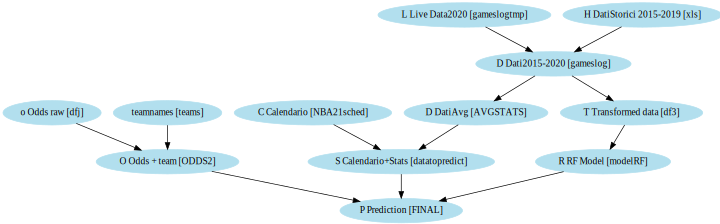

In [437]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'

from graphviz import Digraph
dot = Digraph(comment='NBA Predict',node_attr={'color': 'lightblue2', 'style': 'filled'})
dot.attr(size='10,10')


dot.node('o', 'o Odds raw [dfj]')
dot.node('O', 'O Odds + team [ODDS2]')
dot.node('E', 'teamnames [teams]')

dot.node('L', 'L Live Data2020 [gameslogtmp]')
dot.node('H', 'H DatiStorici 2015-2019 [xls]')
dot.node('D', 'D Dati2015-2020 [gameslog]')
dot.node('T', 'T Transformed data [df3]')
dot.node('R', 'R RF Model [modelRF]')
dot.node('A', 'D DatiAvg [AVGSTATS]')
dot.node('C', 'C Calendario [NBA21sched]')
dot.node('S', 'S Calendario+Stats [datatopredict]')
dot.node('P', 'P Prediction [FINAL]')
dot.edges(['EO','oO','LD','HD','DA','CS','AS','SP','RP','DT','TR','OP'])
dot

# u.edge('5th Edition', 'PWB 1.0')
# u.edge('6th Edition', 'LSX')
# u.edge('6th Edition', '1 BSD')

### LOAD LOCAL DATABASE 

In [228]:
#LOAD LOCAL DATABASE 

import pandas as pd 
import datetime
import numpy as np

gameslogH = pd.read_excel('NBA2020analytics_gamesraw_backup.xls', index_col=0)  
print('gameslogH',gameslogH.shape)
gameslogH = gameslogH.dropna()
max = gameslogH ["GAME_DATE_EST"].max()
min = gameslogH ["GAME_DATE_EST"].min()
print(min,max)


gameslogH (23976, 31)
2015-12-26 00:00:00 2019-12-27 00:00:00


### QUERY NEW DATA

In [2]:

from tqdm import trange
from datetime import date
from datetime import datetime, timedelta
import datetime
from nba_api.stats.endpoints import scoreboardv2
from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd 
import numpy as np

today = date.today()

gameslogtmp = []
for x in trange(365):
    d = datetime.date(2020, 12, 29)
    tmpdate = d - timedelta(x)
    output = scoreboardv2.ScoreboardV2(game_date=tmpdate, league_id='00',timeout=15000).get_data_frames()
    tmp = pd.DataFrame(output[1])
    gameslogtmp= tmp.append(gameslogtmp, ignore_index=True)



100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [07:29<00:00,  1.23s/it]


In [3]:
print('gameslogtmp',gameslogtmp.shape)
gameslogtmp = gameslogtmp.dropna()
max = gameslogtmp ["GAME_DATE_EST"].max()
min = gameslogtmp ["GAME_DATE_EST"].min()
print(min,max)

gameslogtmp (1570, 29)
2019-12-31T00:00:00 2020-12-28T00:00:00


### MERGE LOCAL WITH NEW DATA 
- gameslogH = dati caricati da XLS 
- gameslogtmp = dati new 
- gameslog = il DF finale, backuppato anche su csv e XLS 


In [195]:
print(gameslogH.shape)
print(gameslogtmp.shape)
gameslog=gameslogH.append(gameslogtmp)

import datetime 
gameslog['GAME_DATE_EST'] = pd.to_datetime(gameslog['GAME_DATE_EST']) # convert to date  
gameslog['YEAR'] = gameslog['GAME_DATE_EST'].dt.to_period('Y')  # create column Year
print(gameslog.groupby(['YEAR']).size())
print(gameslog ["GAME_DATE_EST"].min(),gameslog ["GAME_DATE_EST"].max())
print(gameslog.shape)

gameslog.to_csv('NBA2020analytics_gamesraw_backup.csv', index=False)
gameslog.to_excel('NBA2020analytics_gamesraw_backup.xls')

### Transform data in game data ( one line per match ) 

In [21]:

print('gameslog',gameslog.shape)

output = leaguedashteamstats.LeagueDashTeamStats(last_n_games='0', measure_type_detailed_defense='Base', month='0', opponent_team_id=0, pace_adjust='N', per_mode_detailed='Totals', period='0', plus_minus='N', rank='N', season='2019-20', season_type_all_star='Regular Season', conference_nullable='', date_from_nullable='', date_to_nullable='', division_simple_nullable='', game_scope_simple_nullable='', game_segment_nullable='', league_id_nullable='', location_nullable='', outcome_nullable='', po_round_nullable='', player_experience_nullable='', player_position_abbreviation_nullable='', season_segment_nullable='', shot_clock_range_nullable='', starter_bench_nullable='', team_id_nullable='', two_way_nullable='', vs_conference_nullable='', vs_division_nullable='').get_data_frames()
avg_stats = pd.DataFrame(output[0])
print('avg_stats',avg_stats.shape)
gameslog

df1=gameslog[['YEAR','GAME_DATE_EST', 'GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID','TEAM_ABBREVIATION','TEAM_CITY_NAME','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2=df1[['YEAR','GAME_DATE_EST','GAME_ID','TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
df2

df3 = pd.DataFrame([y.values.ravel() for x , y in df2.groupby(np.arange(len(df2))//2)])
df3.columns= ['YEARA','DATEA','GAME_IDA','TEAMA','PTSA','FG_PCTA','FT_PCTA','FG3_PCTA','ASTA','REBA','TOVA','YEARH','DATEH','GAME_IDH','TEAMH','PTSH','FG_PCTH','FT_PCTH','FG3_PCTH','ASTH','REBH','TOVH'] #COLUMNSRENAME
df3=df3[['YEARA','DATEA','GAME_IDH','TEAMH','PTSH','TEAMA','PTSA','FG_PCTH','FG_PCTA','FT_PCTH','FT_PCTA','FG3_PCTH','FG3_PCTA','ASTH','ASTA','REBH','REBA','TOVH','TOVA']] #COLUMNSSELECT
df3['WIN']=''

for i, row in df3.iterrows():
    if (row['PTSH']> row['PTSA']):
        df3.at[i,'WINTEAMNAME'] = row['TEAMH']
        df3.at[i,'WINTEAMNUM'] = 1
    else:
        df3.at[i,'WINTEAMNAME'] = row['TEAMH']
        df3.at[i,'WINTEAMNUM'] = 0

df3.head()
print(df3.groupby(['YEARA']).size())

gameslog (23976, 31)
avg_stats (30, 56)
YEARA
2015      98
2016    2870
2017    2852
2018    2792
2019    2609
2020     767
Freq: A-DEC, dtype: int64


In [27]:
df3.to_csv('NBA2020analytics_gamestransformed_backup.csv', index=False)
df3.to_excel('NBA2020analytics_gamestransformed_backup.xls')

### Create DecisionTree and Random Forest

In [3]:
# OPTIONAL - LOAD LOCAL gamestransformed FILE 

import pandas as pd 
import numpy as np
df3 = pd.read_excel('NBA2020analytics_gamestransformed_backup.xls', index_col=0)  
print('df3',df3.shape)
print(df3.groupby(['YEARA']).size())


df3 (11988, 22)
YEARA
2015      98
2016    2870
2017    2852
2018    2792
2019    2609
2020     767
dtype: int64


### 1 DecisionTree

In [73]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree

y = df3.WINTEAMNUM  #1 TEAMH , 0 TEAMA
df3_features = ['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']
X = df3[df3_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
print(train_X.shape,val_X.shape)

modelDT = DecisionTreeRegressor(max_leaf_nodes=10, random_state=1)
modelDT.fit(train_X, train_y)
preds_val = modelDT.predict(val_X)
print("DecisionTreeRegressor")
print(mean_absolute_error(val_y, preds_val))
modelDT_mae= mean_absolute_error(val_y, preds_val)


(8991, 12) (2997, 12)
DecisionTreeRegressor
0.3000791680852499


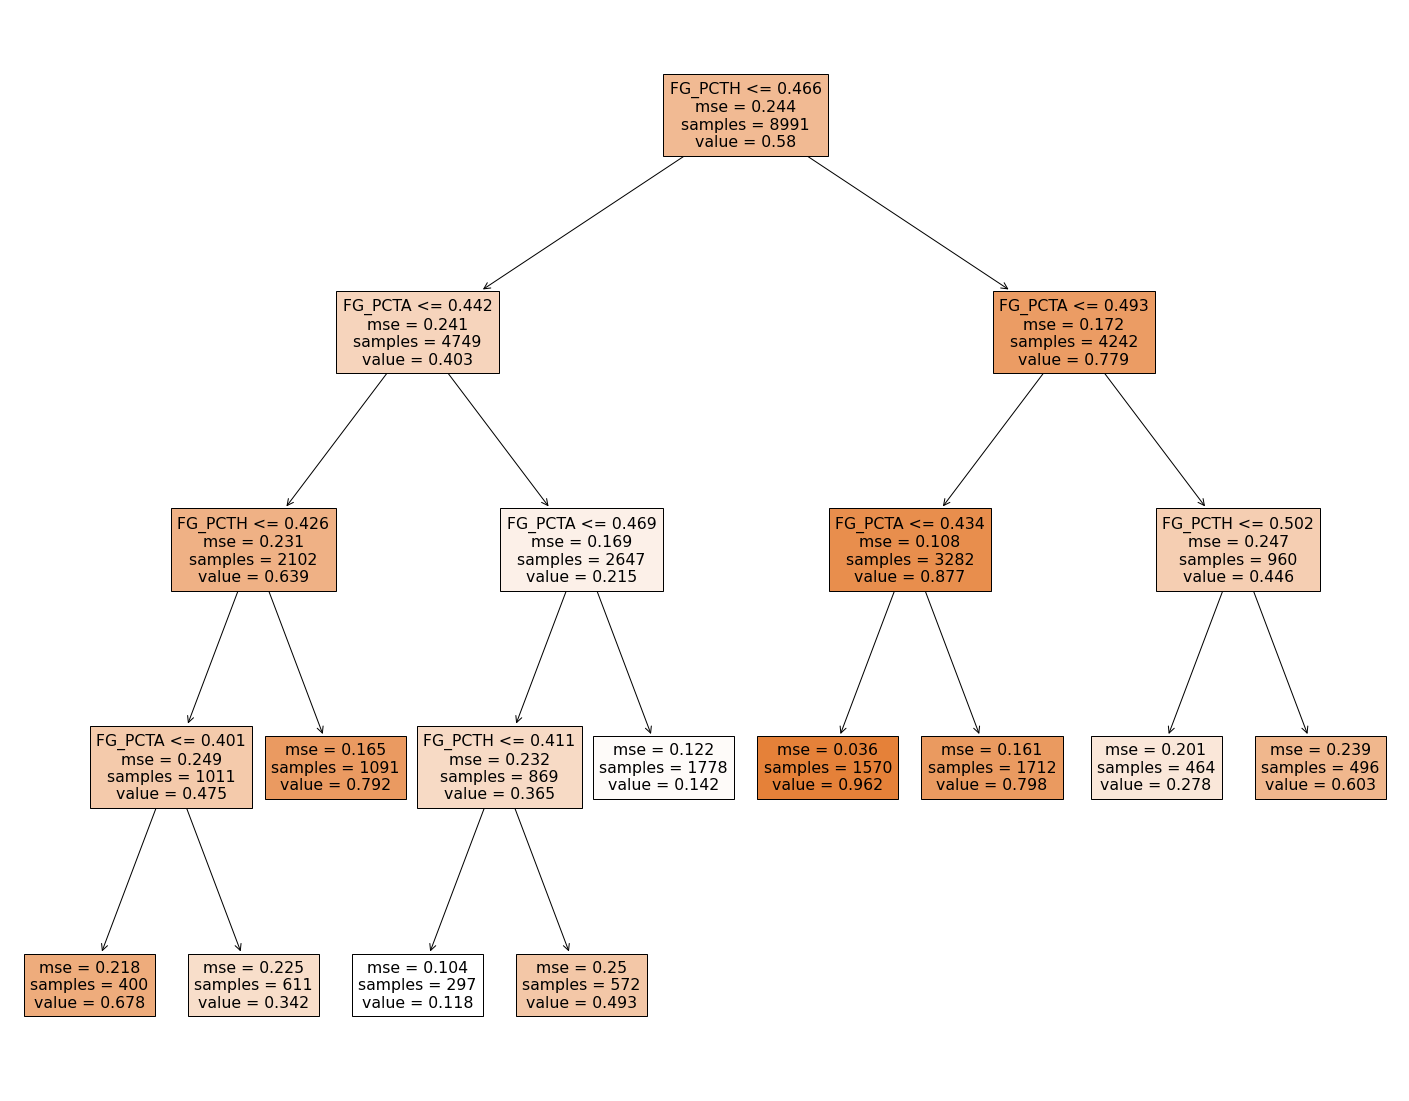

In [71]:
#https://mljar.com/blog/visualize-decision-tree/

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(modelDT,feature_names=val_X.columns, filled=True)

 #1 TEAMH , 0 TEAMA

### 2 Random Forest

In [169]:
import pandas as pd
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn import tree

y = df3.WINTEAMNUM  #1 TEAMH , 0 TEAMA
df3_features = ['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']
X = df3[df3_features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
print(train_X.shape,val_X.shape)

# #TEST TO OPTIMIZE n_estimators + max_depth
# start_time = time.time()
# for j in [1,2,25,50,100]:
#     modelRF = RandomForestClassifier(n_estimators=j,max_depth=25, random_state=0)
#     modelRF.fit(train_X, train_y)
#     preds_val = modelRF.predict(val_X)
#     modelRF_mae=mean_absolute_error(val_y, preds_val)
#     print("depth %.1f  mae %.4f " % (j,modelRF_mae))
# print("TOT seconds ","%.2f" %(time.time() - start_time))

start_time = time.time()
modelRF = RandomForestRegressor(max_depth=25, random_state=0)
modelRF.fit(train_X, train_y)
preds_val = modelRF.predict(val_X)
modelRF_mae=mean_absolute_error(val_y, preds_val)
print("RandomForestRegressor mae : %.4f " % (modelRF_mae))
print("TOT seconds ","%.2f" %(time.time() - start_time))


(8991, 12) (2997, 12)
RandomForestRegressor mae : 0.1221 
TOT seconds  3.55


In [396]:
import pickle
import sys

print("DT model size MB:", sys.getsizeof(pickle.dumps(modelDT))/1000000)
print("RF model size MB:", sys.getsizeof(pickle.dumps(modelRF))/1000000)

DT model size MB: 0.002213
RF model size MB: 7.15445


## PREDICTION WITH BOTH MODELS 

## ( CALENDAR + AVG STATS ) + MODEL = PREDICTION 

In [442]:
import numpy as np
import pandas as pd

#1 LOAD CALENDAR

df = pd.read_csv("NBA2021schedule.csv",sep=";")
df=df.loc[df['Value'].str.startswith('@') == False]
df=df.rename(columns={"Value": "AWAY", "Attribute": "HOME"})
df = df[['GAMEDATE','HOME','AWAY']]
df['AWAY'] = df['AWAY'].apply(lambda x: x.upper())
df['HOME'] = df['HOME'].apply(lambda x: x.upper())
df= df.reset_index()
df['HOME'] = df['HOME'].str.replace('PHO','PHX')
df['AWAY'] = df['AWAY'].str.replace('PHO','PHX')
df['HOME'] = df['HOME'].str.replace('NOR','NOP')
df['AWAY'] = df['AWAY'].str.replace('NOR','NOP')
df['HOME'] = df['HOME'].str.replace('NO','NOP')
df['AWAY'] = df['AWAY'].str.replace('NO','NOP')
df['HOME'] = df['HOME'].str.replace('NY','NYK')
df['AWAY'] = df['AWAY'].str.replace('NY','NYK')
df['HOME'] = df['HOME'].str.replace('SA','SAS')
df['AWAY'] = df['AWAY'].str.replace('SA','SAS')
df['HOME'] = df['HOME'].str.replace('UTH','UTA')
df['AWAY'] = df['AWAY'].str.replace('UTH','UTA')
NBA21sched = df

#2 COMPUTE AVG STATS 

pandas.options.display.float_format = '{:,.2f}'.format
gameslogHZ=gameslogH.loc[gameslogH['YEAR'] == 2019]
gameslogHZ=gameslogHZ[['TEAM_ABBREVIATION','PTS','FG_PCT','FT_PCT','FG3_PCT','AST','REB','TOV']]
gameslogHP=gameslogHZ.groupby('TEAM_ABBREVIATION').mean().reset_index().sort_values(by='FG_PCT', ascending=False)
gameslogHP.head(2)

#3 MERGE CALENDAR + AVG STATS 

gameslogHP = gameslogHP.rename(columns={'TEAM_ABBREVIATION': 'HOME'})
tmpp = pd.merge(gameslogHP, NBA21sched)
tmpp.columns= ['HOME', 'PTSA', 'FG_PCTA', 'FT_PCTA', 'FG3_PCTA', 'ASTA', 'REBA', 'TOVA','index', 'GAMEDATE', 'AWAY']
gameslogHP = gameslogHP.rename(columns={'HOME': 'AWAY'})
tmp2 = pd.merge(gameslogHP, tmpp)
tmp2.columns = ['TEAMA', 'PTSH', 'FG_PCTH', 'FT_PCTH', 'FG3_PCTH', 'ASTH', 'REBH', 'TOVH','TEAMH','PTSA', 'FG_PCTA', 'FT_PCTA', 'FG3_PCTA', 'ASTA', 'REBA', 'TOVA','index', 'GAMEDATE']
AVGSTATS=tmp2[['GAMEDATE','TEAMH','PTSH','TEAMA','PTSA','FG_PCTH','FG_PCTA','FT_PCTH','FT_PCTA','FG3_PCTH','FG3_PCTA','ASTH','ASTA','REBH','REBA','TOVH','TOVA']] #COLUMNSSELECT
print(AVGSTATS.shape)

# 4 DATAFRAME datatopredict
AVGSTATS.head(3)
datatopredict=AVGSTATS[['FG_PCTH','FG_PCTA', 'FT_PCTH', 'FT_PCTA', 'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA','REBH', 'REBA', 'TOVH', 'TOVA']]
datatopredict.head(3)

# 5 MAKE PREDICTION 

resultDT = modelDT.predict(datatopredict)
resultRF = modelRF.predict(datatopredict)
np.set_printoptions(precision=2)
PREDICT_OUT = pd.DataFrame({'resultDT':resultDT, 'resultRF':resultRF})
FINAL = pd.merge(PREDICT_OUT, datatopredict, left_index=True, right_index=True)
FINAL

#6 ADD TEAM INFO AND WINNER NAME

tmp21=AVGSTATS[['GAMEDATE', 'TEAMH','TEAMA']]
FINAL= pd.merge(FINAL, tmp21, left_index=True, right_index=True)

i=0
for index, row in tmp22.iterrows():
    FINAL.at[i, 'GAMEDATE2'] = datetime.strptime(row['GAMEDATE'], '%d/%m/%Y')
    FINAL.at[i, 'GAMETEAMS'] = row['TEAMH']+row['TEAMA']
    FINAL.at[i, 'WINNER_ID'] = round(row['resultRF'])
    if (round(row['resultRF'])==0):    #1 TEAMH , 0 TEAMA
        win=row['TEAMA']
    else:
        win=row['TEAMH']
    FINAL.at[i, 'WINNER_NAME'] = win
    i=i+1

FINAL=FINAL.sort_values(by='GAMEDATE2', ascending=True)
FINAL


(468, 17)


,resultDT,resultRF,FG_PCTH,FG_PCTA,FT_PCTH,FT_PCTA,FG3_PCTH,FG3_PCTA,ASTH,ASTA,...,REBA,TOVH,TOVA,GAMEDATE,TEAMH,TEAMA,GAMEDATE2,GAMETEAMS,WINNER_ID,WINNER_NAME
144,0.14,0.55,0.46,0.47,0.77,0.71,0.37,0.33,24.62,26.22,...,46.19,14.45,15.46,22/12/2020,LAL,LAC,2020-12-22,LALLAC,1.00,LAL
66,0.80,0.72,0.47,0.45,0.80,0.75,0.36,0.35,27.69,23.84,...,47.63,14.10,14.93,22/12/2020,BKN,GSW,2020-12-22,BKNGSW,1.00,BKN
262,0.49,0.62,0.46,0.45,0.75,0.80,0.36,0.36,23.01,21.38,...,44.24,13.60,13.54,23/12/2020,HOU,OKC,2020-12-23,HOUOKC,1.00,HOU
335,0.49,0.42,0.45,0.45,0.76,0.78,0.36,0.34,23.65,23.87,...,45.71,13.25,13.75,23/12/2020,MIN,DET,2020-12-23,MINDET,0.00,DET
171,0.49,0.57,0.46,0.46,0.76,0.81,0.36,0.36,24.75,22.14,...,47.06,14.95,13.14,23/12/2020,POR,UTA,2020-12-23,PORUTA,1.00,POR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.14,0.10,0.46,0.47,0.75,0.79,0.36,0.38,23.01,24.26,...,45.29,13.60,12.33,04/03/2021,SAS,OKC,2021-03-04,SASOKC,0.00,OKC
226,0.49,0.53,0.46,0.46,0.81,0.80,0.37,0.36,25.34,25.08,...,45.17,13.43,12.88,04/03/2021,BOS,TOR,2021-03-04,BOSTOR,1.00,BOS
96,0.80,0.57,0.47,0.46,0.73,0.74,0.36,0.35,25.28,26.11,...,46.40,14.82,15.05,04/03/2021,NOP,MIA,2021-03-04,NOPMIA,1.00,NOP
147,0.49,0.55,0.46,0.47,0.77,0.78,0.37,0.36,24.62,27.20,...,43.23,14.45,13.56,04/03/2021,WAS,LAC,2021-03-04,WASLAC,1.00,WAS


In [456]:
odds2

,teams,commence_time,home_team,team1,team2,AvgOdds1,AvgOdds2,MinOdds1,MinOdds2,MaxOdds1,MaxOdds2,team1S,team2S,TEAMH,TEAMA,GAMETEAMS
0,"[Chicago Bulls, Washington Wizards]",1609287000,Washington Wizards,Chicago Bulls,Washington Wizards,3.09,1.41,3.05,1.40,3.16,1.44,CHI,WAS,WAS,CHI,WASCHI
1,"[Boston Celtics, Indiana Pacers]",1609287000,Indiana Pacers,Boston Celtics,Indiana Pacers,1.95,1.93,1.92,1.92,2.02,1.94,BOS,IND,IND,BOS,INDBOS
2,"[Cleveland Cavaliers, New York Knicks]",1609287000,Cleveland Cavaliers,Cleveland Cavaliers,New York Knicks,1.66,2.30,1.64,2.25,1.70,2.35,CLE,NYK,CLE,NYK,CLENYK
3,"[Philadelphia 76ers, Toronto Raptors]",1609287000,Philadelphia 76ers,Philadelphia 76ers,Toronto Raptors,1.86,2.03,1.83,2.02,1.92,2.06,PHI,TOR,PHI,TOR,PHITOR
4,"[Detroit Pistons, Golden State Warriors]",1609287000,Detroit Pistons,Detroit Pistons,Golden State Warriors,2.55,1.56,2.51,1.54,2.60,1.57,DET,GSW,DET,GSW,DETGSW
5,"[Miami Heat, Milwaukee Bucks]",1609288800,Miami Heat,Miami Heat,Milwaukee Bucks,2.83,1.46,2.80,1.45,2.89,1.47,MIA,MIL,MIA,MIL,MIAMIL
6,"[Oklahoma City Thunder, Orlando Magic]",1609290600,Oklahoma City Thunder,Oklahoma City Thunder,Orlando Magic,2.74,1.51,2.70,1.48,2.77,1.54,OKC,ORL,OKC,ORL,OKCORL
7,"[New Orleans Pelicans, Phoenix Suns]",1609297800,Phoenix Suns,New Orleans Pelicans,Phoenix Suns,2.21,1.71,2.20,1.70,2.24,1.73,NOP,PHX,PHX,NOP,PHXNOP
8,"[Los Angeles Clippers, Minnesota Timberwolves]",1609297800,Los Angeles Clippers,Los Angeles Clippers,Minnesota Timberwolves,1.19,5.15,1.18,4.85,1.22,5.60,LAC,MIN,LAC,MIN,LACMIN
9,"[Denver Nuggets, Sacramento Kings]",1609297800,Sacramento Kings,Denver Nuggets,Sacramento Kings,1.75,2.16,1.74,2.15,1.77,2.17,DEN,SAC,SAC,DEN,SACDEN


In [455]:
print(odds2.shape)
FINALODDS = pd.merge(FINAL, odds2)
FINALODDS.columns

Index(['resultDT', 'resultRF', 'FG_PCTH', 'FG_PCTA', 'FT_PCTH', 'FT_PCTA',
       'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA', 'REBH', 'REBA', 'TOVH', 'TOVA',
       TEAMH', 'TEAMA', 'GAMEDATE2', 'GAMETEAMS', 'WINNER_ID',
       'WINNER_NAME', 'teams', 'commence_time', 'home_team', 'team1', 'team2',
       'AvgOdds1', 'AvgOdds2', 'MinOdds1', 'MinOdds2', 'MaxOdds1', 'MaxOdds2',
       'team1S', 'team2S'],

#FIX2


(10, 16)


Index(['resultDT', 'resultRF', 'FG_PCTH', 'FG_PCTA', 'FT_PCTH', 'FT_PCTA',
       'FG3_PCTH', 'FG3_PCTA', 'ASTH', 'ASTA', 'REBH', 'REBA', 'TOVH', 'TOVA',
       'GAMEDATE', 'TEAMH', 'TEAMA', 'GAMEDATE2', 'GAMETEAMS', 'WINNER_ID',
       'WINNER_NAME', 'teams', 'commence_time', 'home_team', 'team1', 'team2',
       'AvgOdds1', 'AvgOdds2', 'MinOdds1', 'MinOdds2', 'MaxOdds1', 'MaxOdds2',
       'team1S', 'team2S'],
      dtype='object')

In [381]:
FINAL.to_csv('NBA2020_Prediction_out.csv', index=False)
FINAL.to_excel('NBA2020_Prediction_out.xls')